In [1]:
import sys, os, io
import dvc.api
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
from scripts.dataloader import DataLoader
from scripts.exploration import Exploration

In [3]:
train_data = '../data/clean/train.csv'
test_data = '../data/clean/test.csv'
store_data = '../data/clean/store.csv'

### Load the data from Gdrive

In [4]:
dataloader = DataLoader()
exp = Exploration()
repo = 'https://github.com/Haylemicheal/Pharmaceutical-Sales-Prediction/'
content_train =dvc.api.read(path=train_data, repo=repo, rev='cleaned-v')
df_train = dataloader.read_csv(io.StringIO(content_train))
content_store =dvc.api.read(path=store_data, repo=repo, rev='cleaned-v')
df_store = dataloader.read_csv(io.StringIO(content_store))
content_test =dvc.api.read(path=test_data, repo=repo, rev='cleaned-v')
df_test = dataloader.read_csv(io.StringIO(content_test))

## Questions

1. Check for distribution in both training and test sets - are the promotions distributed similarly between these two groups?

In [5]:
train_promo = df_train['Promo']
test_promo = df_test['Promo']

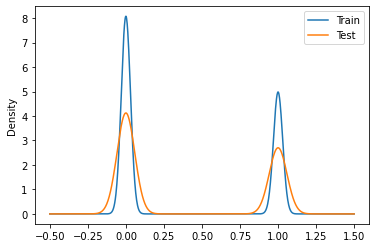

In [31]:
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(111)
train_promo.plot(kind= 'kde' )
pyplot.subplot(111)
test_promo.plot(kind= 'kde')
pyplot.legend(['Train', 'Test'])
pyplot.show()

The distribution of the promo is almost the same in train and test data

### Check & compare sales behavior before, during and after holidays


In [32]:
df_train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

StateHoliday

- 0 -> None
- a -> Public Holiday
- b -> Easter
- c -> Christmass

In [38]:
import pandas as pd
christmas_date = df_train[df_train['StateHoliday'] == 'c']
christmas_dates = christmas_date.groupby('Date')['Date'].unique().index
pd.to_datetime(christmas_dates)

DatetimeIndex(['2013-12-25', '2013-12-26', '2014-12-25', '2014-12-26'], dtype='datetime64[ns]', name='Date', freq=None)

In [46]:
grouped_by_date = df_train.groupby(
    'Date')[['Sales']]
grouped_by_date = grouped_by_date.sum()
grouped_by_date.head()

,Sales
Date,
2013-01-01,97235
2013-01-02,6949829
2013-01-03,6347820
2013-01-04,6638954
2013-01-05,5951593


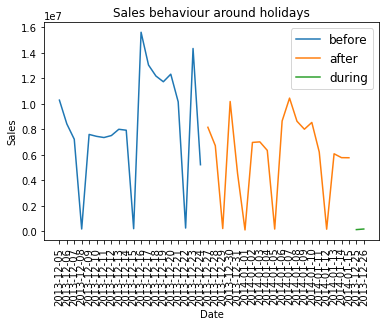

In [59]:
from turtle import color
import seaborn as sns

before_christmass_idx = grouped_by_date[pd.to_datetime(grouped_by_date.index) < christmas_dates[0]].index[-20:]
after_christmass_idx = grouped_by_date[pd.to_datetime(grouped_by_date.index) > christmas_dates[1]].index[:20]
during_christmass_idx = christmas_dates[:2]

before_christmass = grouped_by_date[grouped_by_date.index.isin(before_christmass_idx)]
after_christmass = grouped_by_date[grouped_by_date.index.isin(after_christmass_idx)]
during_christmass = grouped_by_date[grouped_by_date.index.isin(during_christmass_idx)]

# sns.set()
sns.lineplot(x=before_christmass.index, y=before_christmass['Sales'])
sns.lineplot(x=after_christmass.index, y=after_christmass['Sales'])
ax = sns.lineplot(x=during_christmass.index, y=during_christmass['Sales'])
ax.set_title("Sales behaviour around holidays")
pyplot.xticks(rotation=90)
ax.legend(['before', 'after', 'during'], fontsize=12)

The maximum of the sales is happened before the holiday. The lowest Sales is on the Holyday.

### Find out any seasonal (Christmas, Easter etc) purchase behaviors

The Selling pattern every year is similar.

### What can you say about the correlation between sales and number of customers?

Text(0.5, 1.0, 'Correlation between sales and other features')

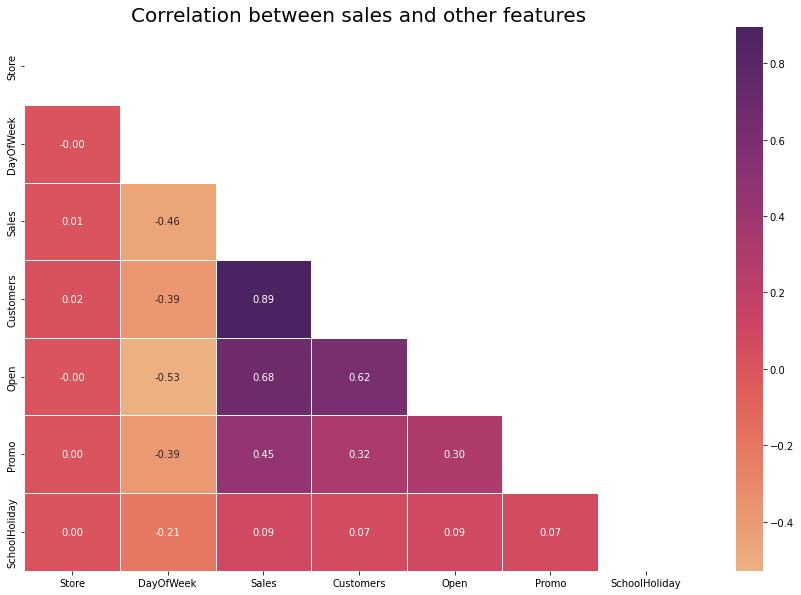

In [71]:
import numpy as np
df_correlation = df_train[['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday']]

upper_triangle = np.zeros_like(df_correlation.corr(), dtype=bool)
upper_triangle[np.triu_indices_from(upper_triangle)] = True
f, ax = pyplot.subplots(figsize=(15, 10))
sns.heatmap(df_correlation.corr(),
            ax=ax,
            annot=True,
            mask=upper_triangle,
            fmt='.2f',
            linewidths=0.5,
            cmap=sns.color_palette("flare", as_cmap=True))
ax.set_title("Correlation between sales and other features", fontsize=20)

### How does promo affect sales? Are the promos attracting more customers? How does it affect already existing customers?